In [1]:
import torch as pt
import importlib
import os
import sys
import numpy as np
from data_utils.ShapeNetDataLoader import PartNormalDataset,pc_normalize

In [2]:
from test_partseg import seg_classes

In [3]:
model_name = 'pointnet2_part_seg_msg'
device_name = 'cuda:0'
# device_name = 'cpu'
num_part = 50
num_classes = 16

In [4]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    new_y = pt.eye(num_classes)[y.cpu().data.numpy(),]
    return new_y.to(device)

In [5]:
# set pytorch
device = pt.device(device_name)

In [6]:
# add env to import model
sys.path.append(os.path.join('./','models'))

In [7]:
# load model
MODEL = importlib.import_module(model_name)
model = MODEL.get_model(num_part,normal_channel=True).to(device)

checkpoint = pt.load('./log/part_seg/pointnet2_part_seg_msg/checkpoints/best_model.pth',map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

model = model.eval()

In [8]:
TEST_DATASET = PartNormalDataset(root = 'data/shapenetcore_partanno_segmentation_benchmark_v0_normal/', npoints=2048, split='test', normal_channel=True)

In [9]:
(points, label, target) = TEST_DATASET[0]
print(label)

[0]


In [10]:
class_str2idx = TEST_DATASET.classes

In [11]:
class_str2idx

{'Airplane': 0,
 'Bag': 1,
 'Cap': 2,
 'Car': 3,
 'Chair': 4,
 'Earphone': 5,
 'Guitar': 6,
 'Knife': 7,
 'Lamp': 8,
 'Laptop': 9,
 'Motorbike': 10,
 'Mug': 11,
 'Pistol': 12,
 'Rocket': 13,
 'Skateboard': 14,
 'Table': 15}

In [18]:
cls = 'Chair'
point_set = np.loadtxt('./data/modelnet40_normal_resampled/chair/chair_0003.txt',delimiter=',').astype(np.float32)
point_set = point_set[0:2048,:]
point_set_display = point_set
point_set[:, 0:6] = pc_normalize(point_set[:, 0:6])
print(point_set.shape)

cls_idx =  pt.Tensor([class_str2idx[cls]])

(2048, 6)


In [19]:
points = pt.Tensor([point_set])
cur_batch_size, NUM_POINT, _ = points.size()
points = points.float().to(device)
points = points.transpose(2, 1)
res, _ = model(points,to_categorical(cls_idx,num_classes))

In [20]:
cur_pred_val = res.cpu().data.numpy()
cur_pred_val_logits = cur_pred_val
cur_pred_val = np.zeros((cur_batch_size, NUM_POINT)).astype(np.int32)

In [17]:
for i in range(cur_batch_size):
    cat = cls
    # 改这一个block的最后一行，seg_classes[cat] 就是[38, 39, 40]这样的用来限制输出节点类型的
    logits = cur_pred_val_logits[i, :, :]
    cur_pred_val[i, :] = np.argmax(logits[:, seg_classes[cat]], 1) + seg_classes[cat][0]

[38, 39, 40]


In [39]:
from random import randint

In [40]:
print(cur_pred_val)

display_color = cur_pred_val[0]
color_options = {}
sorted_by_type = {}
for i in display_color:
    if i not in color_options:
        color_options[i] = 'C%d'%(len(color_options)+2)

for i in range(len(display_color)):
    if display_color[i] not in sorted_by_type:
        sorted_by_type[display_color[i]] = []
    sorted_by_type[display_color[i]].append(i)
print(color_options)
display_color = [color_options[i] for i in display_color]

[[38 39 39 ... 38 38 39]]
{38: 'C2', 39: 'C3'}


In [41]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib inline

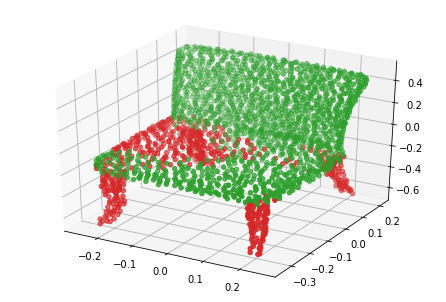

In [42]:
fig = plt.figure()
ax = Axes3D(fig)
for type_i in sorted_by_type:
    point_set_tmp = []
    color = color_options[type_i]
    for idx in sorted_by_type[type_i]:
        point_set_tmp.append(point_set_display[idx][:3])
    point_set_tmp = np.array(point_set_tmp).T
    point_display_x = point_set_tmp[0]
    point_display_y = point_set_tmp[1]
    point_display_z = point_set_tmp[2]
    ax.scatter(point_display_x, point_display_z, point_display_y, c=color)